## Datos socio demográficos y de recursos de salud a nivel de condado de EE. UU. (2018-2019)
Se han recopilado datos socio demográficos y de recursos de salud por condado en los Estados Unidos y queremos descubrir si existe alguna relación entre los recursos sanitarios y los datos socio demográficos.

## Target
Realizaré un estudio sobre la esperanza de vida, asociada con la mortalidad y la vitalidad poblacional (nacimientos + movimientos migratiorios). Para ello crearé una métrica que integre las tres dimensiones y lo compararé con la prevalencia de obesidad. Debido al volumen nos centraremos en algunas columnas seleccionadas relevantes para el análisis del EDA. 

Mi dataset está basado en este enlace:

https://breathecode.herokuapp.com/asset/internal-link?id=733&path=demographic_health_data.csv

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge



In [248]:
# Cargar los datos
archivo = "https://breathecode.herokuapp.com/asset/internal-link?id=733&path=demographic_health_data.csv"
df = pd.read_csv(archivo, sep=",")

In [249]:
df.head(10)

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2
5,1011,10138,1198,11.816926,1130,11.146183,1395,13.760110,1446,14.263168,...,873,20.6,19.4,21.9,1651,4.5,4.2,4.8,360,6
6,1013,19680,2351,11.946138,2461,12.505081,2286,11.615854,2337,11.875000,...,1741,18.6,17.5,19.5,2841,4.3,4.1,4.6,662,6
7,1015,114277,13141,11.499252,14637,12.808352,15463,13.531157,13865,12.132800,...,9158,14.7,13.6,15.7,13182,3.6,3.3,3.8,3204,4
8,1017,33615,3869,11.509743,3812,11.340176,4380,13.029897,3734,11.108136,...,2870,17.5,16.6,18.5,4664,4.0,3.8,4.2,1068,5
9,1019,26032,2554,9.811002,2981,11.451291,2852,10.955747,2504,9.618931,...,2540,15.9,14.7,17.2,3353,3.9,3.6,4.2,814,6


In [250]:
df.shape

(3140, 108)

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


In [252]:
# Dataset fundamentalmente numérico pero hay dos categóricos (object)
df.select_dtypes(include="object").columns

Index(['COUNTY_NAME', 'STATE_NAME'], dtype='object')

In [253]:
# Detectar si entre las variables numéricas hay columnas potencialmente categóricas que debamos analizar también

umbral_categorica = 10  # nº máx. de valores únicos para sospechar que es categórica
umbral_ratio = 0.05     # si valores únicos / total de filas < 5%, se marca como potencial categórica

resumen_unicos = pd.DataFrame({
    "tipo": df.dtypes,
    "valores_unicos": df.nunique(),
    "porcentaje_unicos": df.nunique() / len(df)
}).sort_values(by="valores_unicos")

# filtrar sospechosos de ser categóricos
posibles_categoricas = resumen_unicos[
    (resumen_unicos["tipo"].isin(["int64", "float64"])) &
    (
        (resumen_unicos["valores_unicos"] <= umbral_categorica) |
        (resumen_unicos["porcentaje_unicos"] <= umbral_ratio)
    )
]
print(display(posibles_categoricas))

# Dar respuesta directa
if posibles_categoricas.empty:
    print("No se detectan variables numéricas con comportamiento categórico")
else:
    print("Estas columnas podrían representar categorías codificadas (por ejemplo, regiones, género, códigos de estado, etc)")


,tipo,valores_unicos,porcentaje_unicos


None
No se detectan variables numéricas con comportamiento categórico


In [254]:
# Control de duplicados
duplicados = df[df.duplicated(keep=False)]
print(f"Número de filas duplicadas: {duplicados.shape[0]}") 
print(duplicados)

Número de filas duplicadas: 0
Empty DataFrame
Columns: [fips, TOT_POP, 0-9, 0-9 y/o % of total pop, 19-Oct, 10-19 y/o % of total pop, 20-29, 20-29 y/o % of total pop, 30-39, 30-39 y/o % of total pop, 40-49, 40-49 y/o % of total pop, 50-59, 50-59 y/o % of total pop, 60-69, 60-69 y/o % of total pop, 70-79, 70-79 y/o % of total pop, 80+, 80+ y/o % of total pop, White-alone pop, % White-alone, Black-alone pop, % Black-alone, Native American/American Indian-alone pop, % NA/AI-alone, Asian-alone pop, % Asian-alone, Hawaiian/Pacific Islander-alone pop, % Hawaiian/PI-alone, Two or more races pop, % Two or more races, POP_ESTIMATE_2018, N_POP_CHG_2018, GQ_ESTIMATES_2018, R_birth_2018, R_death_2018, R_NATURAL_INC_2018, R_INTERNATIONAL_MIG_2018, R_DOMESTIC_MIG_2018, R_NET_MIG_2018, Less than a high school diploma 2014-18, High school diploma only 2014-18, Some college or associate's degree 2014-18, Bachelor's degree or higher 2014-18, Percent of adults with less than a high school diploma 2014-18

In [255]:
# Comprobar valores nulos
valores_nulos = df.isnull().sum().sort_values(ascending=False)
print(valores_nulos.head(20))

fips                        0
TOT_POP                     0
0-9                         0
0-9 y/o % of total pop      0
19-Oct                      0
10-19 y/o % of total pop    0
20-29                       0
20-29 y/o % of total pop    0
30-39                       0
30-39 y/o % of total pop    0
40-49                       0
40-49 y/o % of total pop    0
50-59                       0
50-59 y/o % of total pop    0
60-69                       0
60-69 y/o % of total pop    0
70-79                       0
70-79 y/o % of total pop    0
80+                         0
80+ y/o % of total pop      0
dtype: int64


In [256]:
# Creo un proxy de target, que integre las tres dimensiones mencionadas y sirva como puente para el análisis
num = (df["R_birth_2018"].clip(lower=0) + df["R_NET_MIG_2018"])
den = df["R_death_2018"].replace(0, np.nan) # sustituye los valores cero por valores nulos

df["Life_Expectancy_Proxy"] = (num / den) * 100
# Limpieza de infinitos y NaN residuales
df["Life_Expectancy_Proxy"] = df["Life_Expectancy_Proxy"].replace([np.inf, -np.inf], np.nan)

In [257]:
# Ahora defino el target, excluyendo las columnas no predictivas y definiendo las variables categóricas y numéricas
target = "Life_Expectancy_Proxy"
cols_to_exclude = [
    "fips", "STATE_FIPS", "CNTY_FIPS",
    "COUNTY_NAME", "STATE_NAME",
    # tasas directamente usadas en el cálculo del proxy
    "R_birth_2018", "R_death_2018", "R_NET_MIG_2018",
]
X = df.drop(columns=[c for c in cols_to_exclude if c in df.columns])
y = df[target]
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Target:", target)
print("Variables numéricas:", len(num_cols))
print(num_cols[:15], "...")
print("Variables categóricas:", len(cat_cols))
print(cat_cols)
print(num_cols)


Target: Life_Expectancy_Proxy
Variables numéricas: 101
['TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct', '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop', '30-39', '30-39 y/o % of total pop', '40-49', '40-49 y/o % of total pop', '50-59', '50-59 y/o % of total pop', '60-69', '60-69 y/o % of total pop'] ...
Variables categóricas: 0
[]
['TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct', '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop', '30-39', '30-39 y/o % of total pop', '40-49', '40-49 y/o % of total pop', '50-59', '50-59 y/o % of total pop', '60-69', '60-69 y/o % of total pop', '70-79', '70-79 y/o % of total pop', '80+', '80+ y/o % of total pop', 'White-alone pop', '% White-alone', 'Black-alone pop', '% Black-alone', 'Native American/American Indian-alone pop', '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone', 'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone', 'Two or more races pop', '% Two or more races', 'POP_ESTIMATE_2018', 'N_POP

### Variables categóricas y correlaciones: representación gráfica según la esperanza de vida

In [258]:
df.COUNTY_NAME.value_counts()

COUNTY_NAME
Washington    31
Jefferson     26
Lincoln       24
Franklin      24
Jackson       24
              ..
Vilas          1
Washburn       1
Waukesha       1
Waupaca        1
Waushara       1
Name: count, Length: 1841, dtype: int64

In [259]:
df.STATE_NAME.value_counts()

STATE_NAME
Texas                   254
Georgia                 159
Virginia                133
Kentucky                120
Missouri                115
Kansas                  105
Illinois                102
North Carolina          100
Iowa                     99
Tennessee                95
Nebraska                 93
Indiana                  92
Ohio                     88
Minnesota                87
Michigan                 83
Mississippi              82
Oklahoma                 77
Arkansas                 75
Wisconsin                72
Pennsylvania             67
Alabama                  67
Florida                  67
South Dakota             66
Louisiana                64
Colorado                 64
New York                 62
California               58
Montana                  56
West Virginia            55
North Dakota             53
South Carolina           46
Idaho                    44
Washington               39
Oregon                   36
New Mexico               33
Utah     

/tmp/ipykernel_1883/1241098082.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


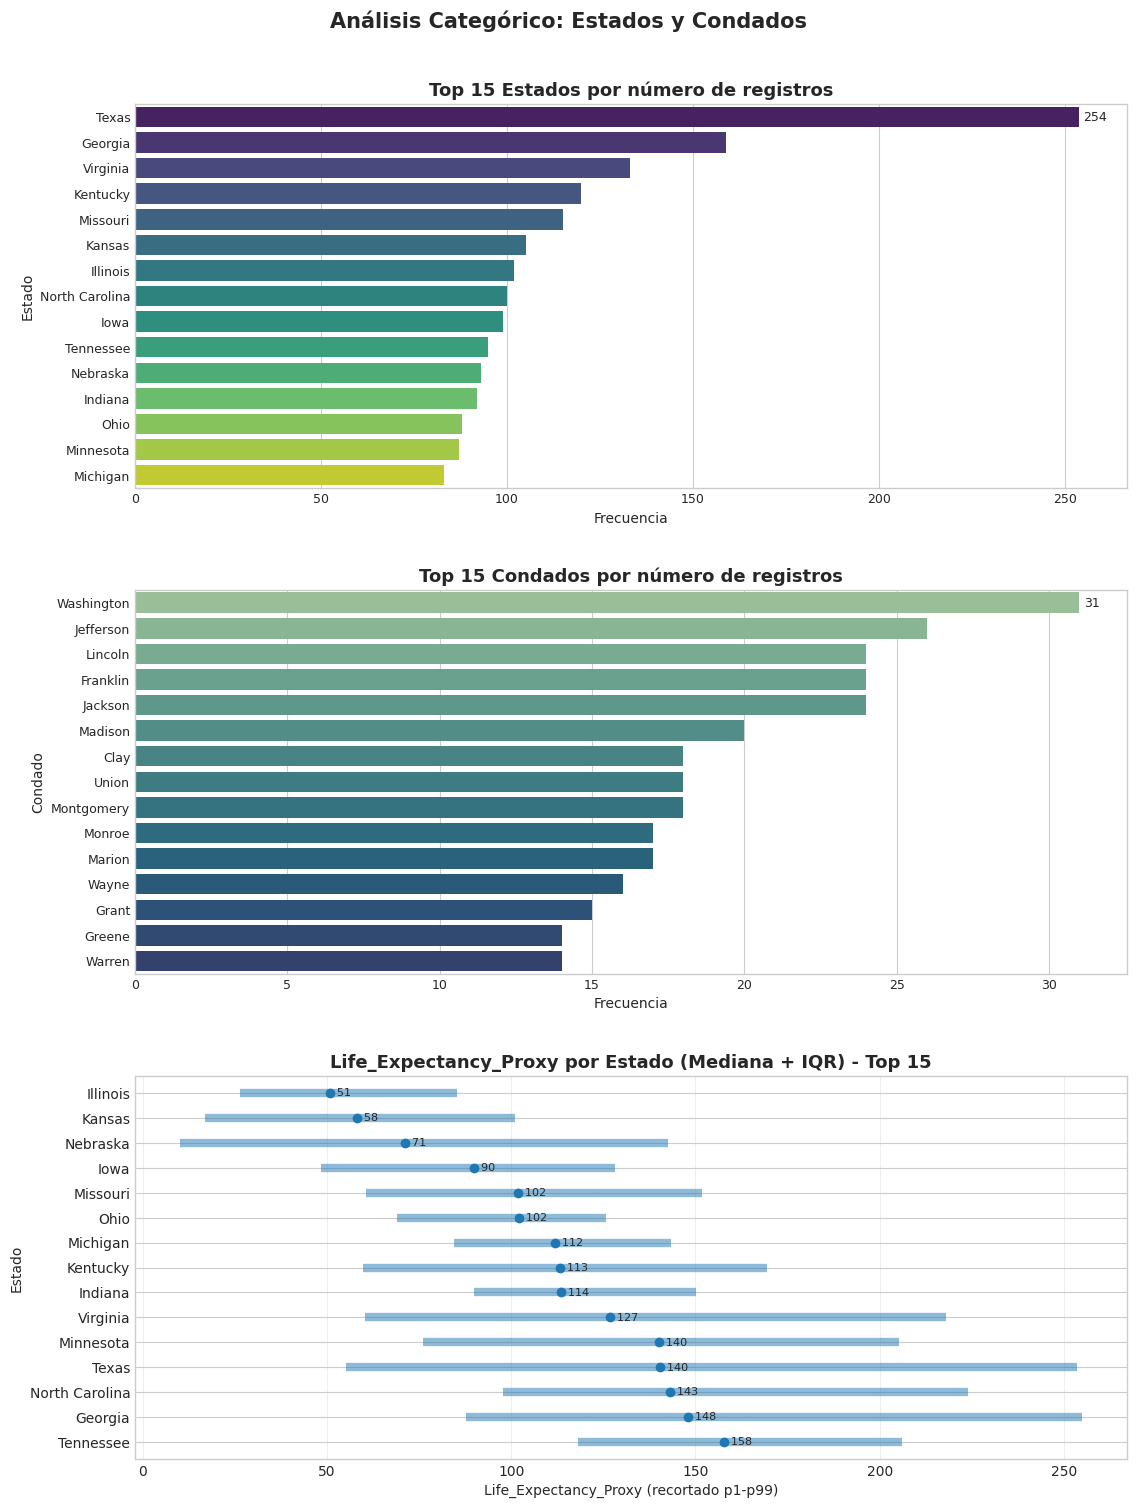

In [260]:
# Configuración del grid
plt.style.use("seaborn-v0_8-whitegrid")

# Top 15 estados y condados
top_states = df["STATE_NAME"].value_counts().head(15)
top_counties = df["COUNTY_NAME"].value_counts().head(15)

# Figura general con 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Gráfico de Top 15 estados
sns.barplot(
    x=top_states.values,
    y=top_states.index,
    ax=axes[0],
    palette="viridis"
)
axes[0].set_title("Top 15 Estados por número de registros", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Frecuencia", fontsize=10)
axes[0].set_ylabel("Estado", fontsize=10)
axes[0].tick_params(axis='both', labelsize=9)
axes[0].bar_label(axes[0].containers[0], fmt="%.0f", padding=3, fontsize=9)


# Gráfico de Top 15 condados
sns.barplot(
    x=top_counties.values,
    y=top_counties.index,
    ax=axes[1],
    hue=top_counties.index,
    palette="crest"
)
axes[1].set_title("Top 15 Condados por número de registros", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Frecuencia", fontsize=10)
axes[1].set_ylabel("Condado", fontsize=10)
axes[1].tick_params(axis='both', labelsize=9)
axes[1].bar_label(axes[1].containers[0], fmt="%.0f", padding=3, fontsize=9)

# Variación del proxy por estado (los 15 registros con más volumen)

states_15 = top_states.index
# Recorte de outliers para mejor legibilidad.
p1, p99 = df["Life_Expectancy_Proxy"].quantile([0.01, 0.99])
df["_LEP_trim"] = df["Life_Expectancy_Proxy"].clip(p1, p99)

agg = (
    df[df["STATE_NAME"].isin(states_15)]
    .groupby("STATE_NAME")["_LEP_trim"]
    .agg(median="median",
         q1=lambda s: s.quantile(0.25),
         q3=lambda s: s.quantile(0.75),
         n="count")
    .sort_values("median", ascending=False)
)

ax = axes[2]
ypos = range(len(agg))
# IQR como línea horizontal
ax.hlines(y=ypos, xmin=agg["q1"], xmax=agg["q3"], linewidth=6, alpha=0.5)
# Mediana como punto
ax.plot(agg["median"], ypos, "o", markersize=6)

ax.set_yticks(list(ypos)); ax.set_yticklabels(agg.index)
ax.set_title("Life_Expectancy_Proxy por Estado (Mediana + IQR) - Top 15", fontsize=13, fontweight="bold")
ax.set_xlabel("Life_Expectancy_Proxy (recortado p1-p99)"); ax.set_ylabel("Estado")
ax.grid(True, axis="x", alpha=0.3)

# Etiquetado de la mediana
for y, v in enumerate(agg["median"]):
    ax.text(v, y, f"  {v:.0f}", va="center", fontsize=8)

plt.tight_layout(pad=3.0)
plt.suptitle("Análisis Categórico: Estados y Condados", fontsize=15, fontweight="bold", y=1.02)
plt.show()

# Limpieza de la columna temporal
df.drop(columns=["_LEP_trim"], inplace=True)

### Estados:

Los 5 primeros estados acumulan más del 50% del total de registros.

La dispersión decrece rápidamente a partir del décimo estado, evidenciando una cola larga con menor representación. Esto sugiere la necesidad de ponderar los análisis posteriores para evitar que los resultados se vean influenciados de forma desproporcionada por las zonas más pobladas o con mayor cobertura de datos.

### Condados:

Alta cardinalidad, por lo tanto se han seleccionado los 15 condados más representativos. Hay una gran concentración de datos en pocos condados, posiblemente aquellos densamente poblados.

### Esperaza de vida por Estado (número de registros)
Se usa un gráfico lollipop con IQR para visualización más limpia, evitando el impacto visual de los outliers (recorte del 1%). El rango intercuantílico estrecho indica cierta estabilidad demográfica, mientras que un rango amplio puede indicar posibles desigualdades.

Los estados del noroeste presentan medianas más altas, reflejando mejores condiciones demográficas para el estudio. Más nacimientos y migración neta frente al número de fallecimientos



### Variables numéricas y correlaciones: representación gráfica según la esperanza de vida

In [261]:
num_df = df.select_dtypes(include=["number"]).copy()
corr_matrix = num_df.corr(numeric_only=True)
corr_target = corr_matrix[target].dropna().sort_values(ascending=False)

# Seleccionar top 5 positivas y 5 negativas para acotar el análisis
top_positive = corr_target[1:6]   # ignorar la autocorrelación con sí misma
top_negative = corr_target[-5:]
top_features = pd.concat([top_positive, top_negative])

print("Variables más correlacionadas con la esperanza de vida (proxy):")
print(top_features)


Variables más correlacionadas con la esperanza de vida (proxy):
R_NET_MIG_2018                0.760786
R_DOMESTIC_MIG_2018           0.730064
CI90LBINC_2018                0.306034
N_POP_CHG_2018                0.305846
MEDHHINC_2018                 0.305071
Heart disease_Lower 95% CI   -0.308423
anycondition_prevalence      -0.308508
CKD_Upper 95% CI             -0.309269
anycondition_Upper 95% CI    -0.309508
R_death_2018                 -0.353171
Name: Life_Expectancy_Proxy, dtype: float64


In [262]:
# Submatriz para las variables más correlacionadas con el target
selected_cols = top_features.index.tolist() + [target]
reduced_corr = num_df[selected_cols].corr(numeric_only=True)

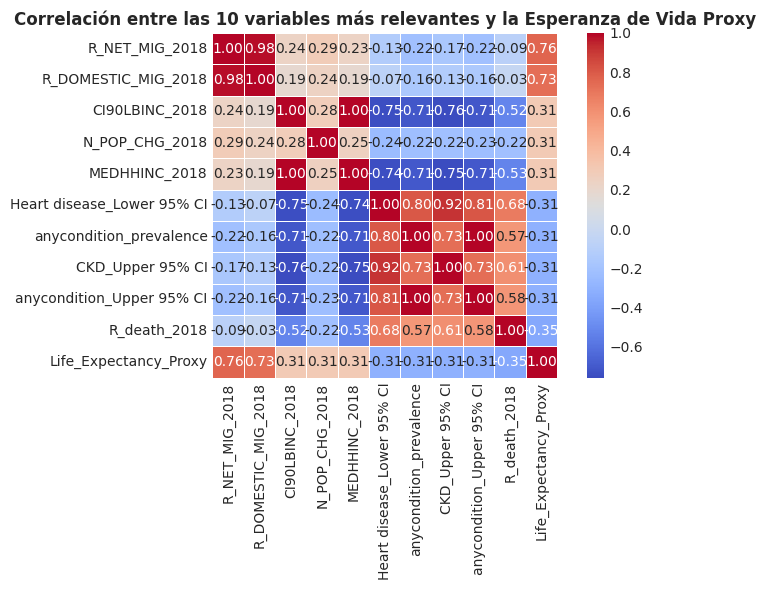

In [263]:
# Heatmap de la submatriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(
    reduced_corr,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    square=True,
)
plt.title("Correlación entre las 10 variables más relevantes y la Esperanza de Vida Proxy", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1883/2125025744.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


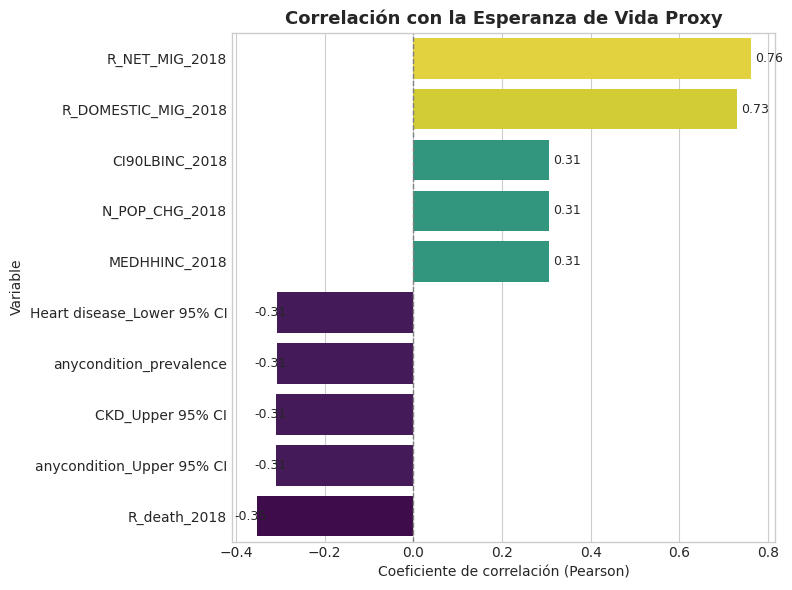

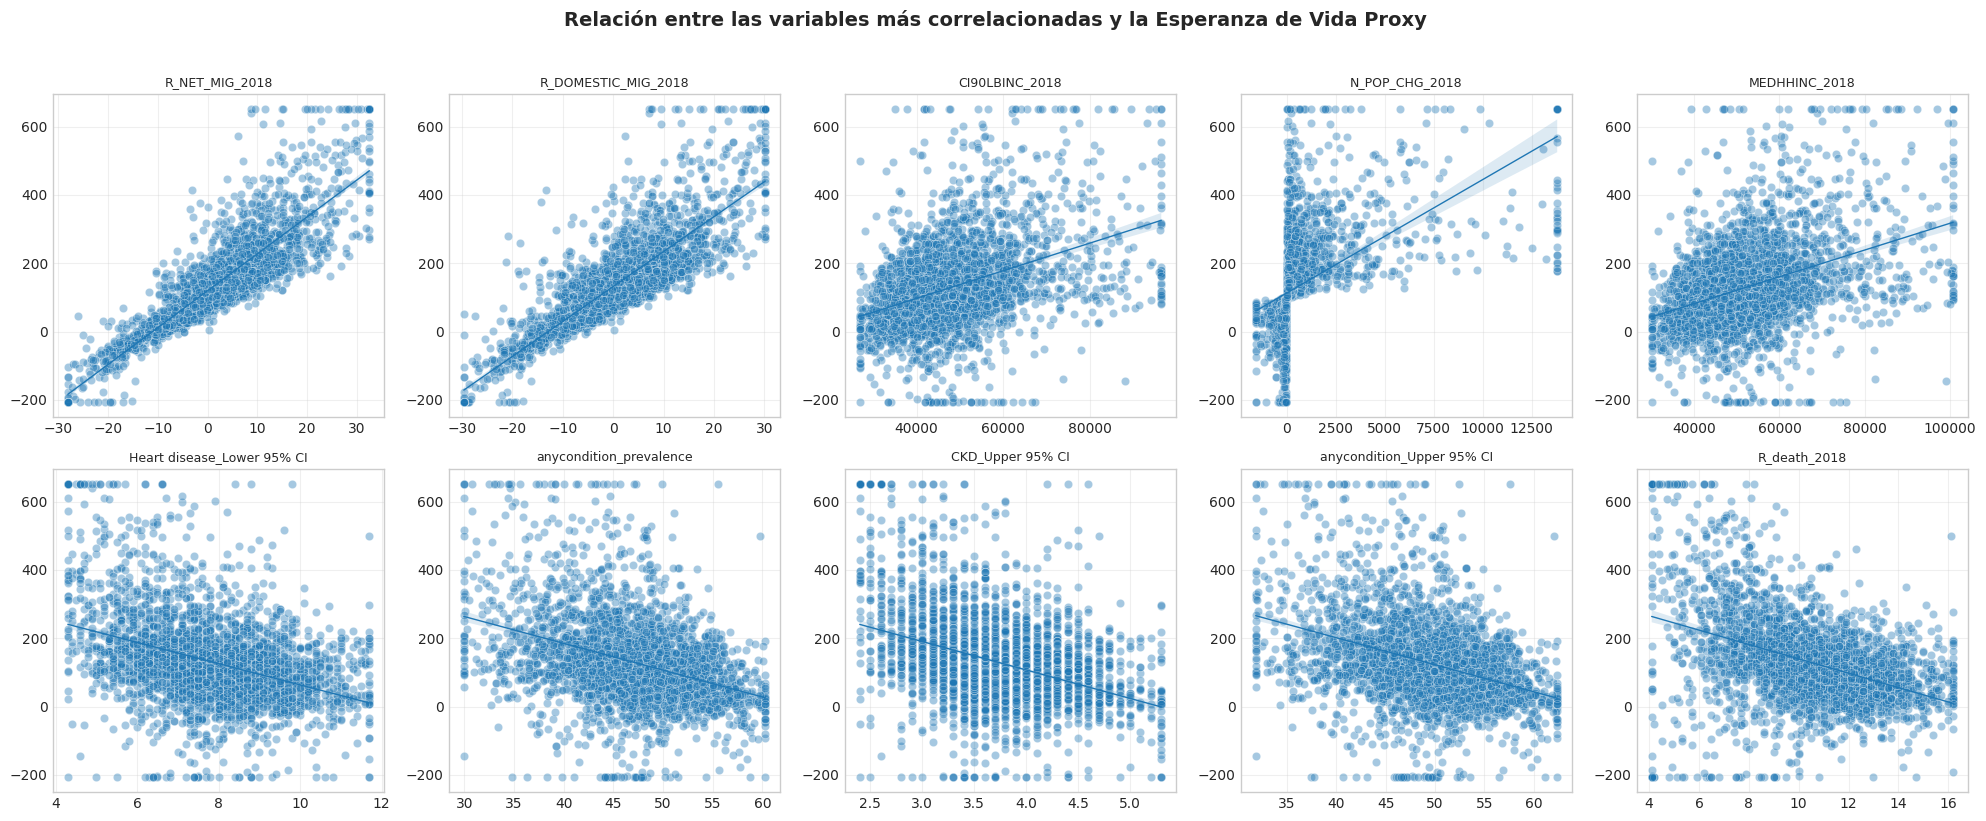

In [264]:
# Quitar el propio target y descartar NaNs en correlación
tf = top_features.drop(labels=[target], errors="ignore").dropna()

# Mantener los top 10 features
tf = tf.iloc[:10]

# Barplot
plt.figure(figsize=(8, 6))
vmin, vmax = float(tf.values.min()), float(tf.values.max())
# Si vmin == vmax (caso extremo), evita división por cero
if vmin == vmax:
    vmin -= 1e-9
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
colors = [cm.viridis(norm(val)) for val in tf.values]

sns.barplot(
    y=tf.index,
    x=tf.values,
    palette=colors
)

plt.title("Correlación con la Esperanza de Vida Proxy", fontsize=13, fontweight="bold")
plt.xlabel("Coeficiente de correlación (Pearson)")
plt.ylabel("Variable")
plt.axvline(0, color="gray", linestyle="--", lw=1)

# Etiquetas numéricas en las barras
for i, (val, name) in enumerate(zip(tf.values, tf.index)):
    offset = 0.01 if val > 0 else -0.05
    plt.text(val + offset, i, f"{val:.2f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()


# Scatterplot y línea de tendencia
n = len(tf)
rows = 2
cols = n if n <= 5 else 5  # primera fila
if n > 5:
    rows = 2
    cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = np.array(axes).reshape(-1)  # aplanar axes

for i, col in enumerate(tf.index):
    ax = axes[i]

    # Subconjunto y coerción a numérico (silenciosa)
    sub = df[[col, target]].copy()
    sub[col] = pd.to_numeric(sub[col], errors="coerce")
    sub[target] = pd.to_numeric(sub[target], errors="coerce")

    # Filtrar finitos
    sub = sub[np.isfinite(sub[col]) & np.isfinite(sub[target])]

    # Si no hay datos o x es constante, mostramos aviso en el panel
    if sub.empty or sub[col].nunique() < 2:
        ax.text(0.5, 0.5, "Sin datos válidos", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(f"{col}", fontsize=9)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(True, alpha=0.3)
        continue

    # Acotar outliers extremos para estabilizar ajuste visual
    x_q1, x_q99 = sub[col].quantile([0.01, 0.99])
    y_q1, y_q99 = sub[target].quantile([0.01, 0.99])
    sub[col] = sub[col].clip(x_q1, x_q99)
    sub[target] = sub[target].clip(y_q1, y_q99)

    # Muestreo para gráficos muy densos
    if len(sub) > 5000:
        sub = sub.sample(5000, random_state=42)

    # Scatter sin hue (evita FutureWarning y leyendas ruidosas)
    sns.scatterplot(data=sub, x=col, y=target, alpha=0.4, ax=ax)

    # Línea de tendencia; si falla por datos degenerados, la omitimos
    try:
        sns.regplot(
            data=sub,
            x=col,
            y=target,
            scatter=False,
            ax=ax,
            line_kws={"linewidth": 1}
        )
    except Exception:
        pass

    ax.set_title(f"{col}", fontsize=9)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(True, alpha=0.3)

# Ocultar ejes sobrantes si n < rows*cols
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.suptitle(
    "Relación entre las variables más correlacionadas y la Esperanza de Vida Proxy",
    fontsize=14,
    fontweight="bold",
    y=1.02
)
plt.tight_layout()
plt.show()

El dataset presenta un número considerable de variables numéricas asociadas a indicadores demográficos, socioeconómicos y sanitarios, lo que permite un análisis amplio de correlaciones y patrones de comportamiento.

La mayor parte de las variables muestran distribuciones asimétricas a la derecha, con colas largas derivadas de valores extremos (outliers) en regiones específicas.

Se observa una variabilidad sustancial entre los distintos indicadores, lo que sugiere heterogeneidad territorial en las condiciones demográficas y de salud, como altas tasa de migración en ciertos estados, indicadores de mortalidad y natalidad con valores extremos en zonas rurales.

Los indicadores de enfermedades se correlacionan con el proxy con el patrón de mayor incidencia de enfermedad = menor expectativa de vida.

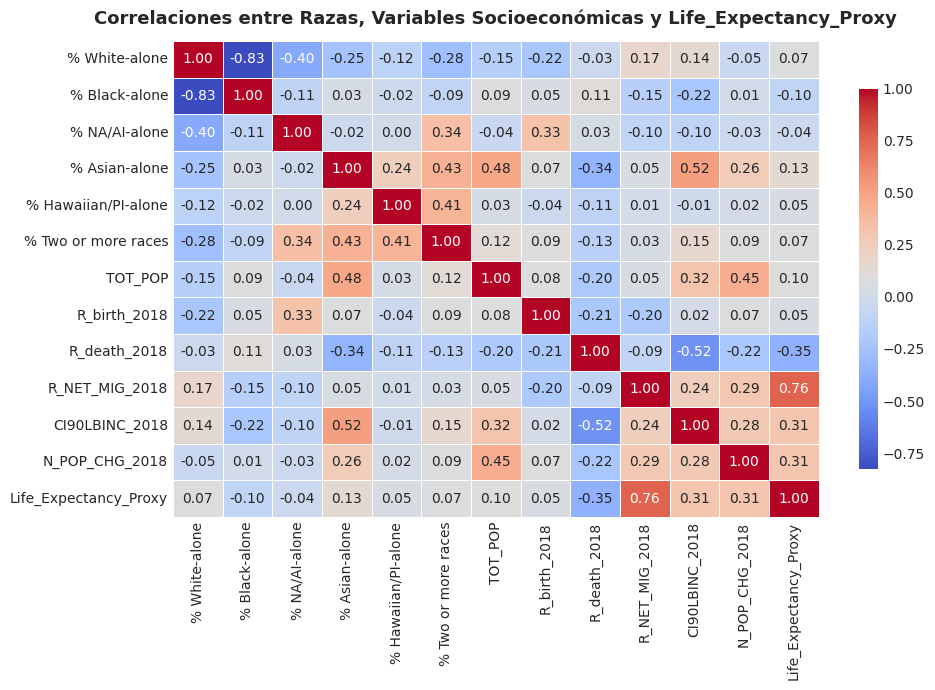

In [265]:
# Correlación entre raza y proxy
race_cols = [
    "% White-alone",
    "% Black-alone",
    "% NA/AI-alone",
    "% Asian-alone",
    "% Hawaiian/PI-alone",
    "% Two or more races"
]

# Factores socioeconómicos
socio_cols = [
    "TOT_POP",
    "R_birth_2018",
    "R_death_2018",
    "R_NET_MIG_2018",
    "CI90LBINC_2018",
    "N_POP_CHG_2018"
]

# Correlación con Life Expectancy
subset_cols = race_cols + socio_cols + ["Life_Expectancy_Proxy"]
corr_combined = df[subset_cols].corr(numeric_only=True)


# Gráfico
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_combined,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlaciones entre Razas, Variables Socioeconómicas y Life_Expectancy_Proxy",
          fontsize=13, fontweight="bold", pad=12)
plt.tight_layout()
plt.show()

El heatmap de raza permite observar de forma integrada las relaciones entre composición racial, indicadores demográficos y el proxy de esperanza de vida.

Se distinguen dos bloques de correlación:

Un bloque positivo: raza blanca y asiática y variables asociadas al crecimiento poblacional (R_NET_MIG_2018, N_POP_CHG_2018).

Un bloque negativo, donde destacan raza negra y amerindia, con correlaciones inversas respecto a Life_Expectancy_Proxy y valores asociados a tasas de mortalidad elevadas (R_death_2018).

,Correlación
Percent of adults with a bachelor's degree or higher 2014-18,0.284537
Percent of adults completing some college or associate's degree 2014-18,0.048366
Percent of adults with less than a high school diploma 2014-18,-0.158069
Percent of adults with a high school diploma only 2014-18,-0.270270


/tmp/ipykernel_1883/589589205.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


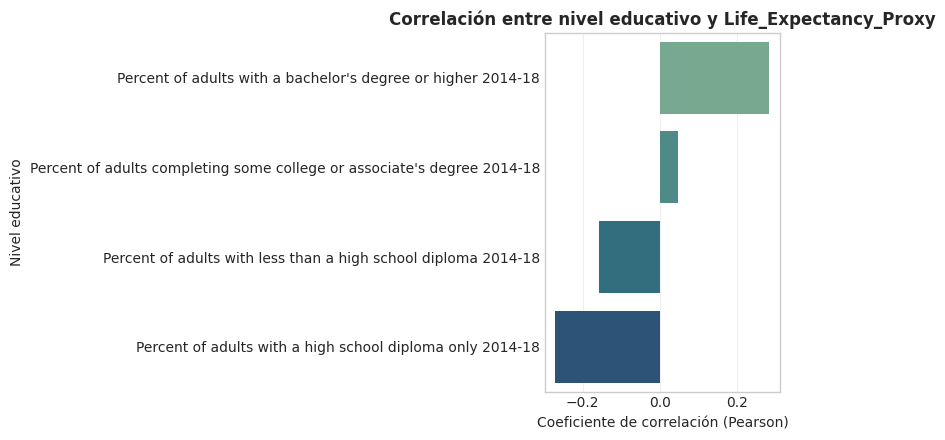

In [266]:
# Correlación entre nivel educativo y proxy

education_cols = [
    "Percent of adults with less than a high school diploma 2014-18",
    "Percent of adults with a high school diploma only 2014-18",
    "Percent of adults completing some college or associate's degree 2014-18",
    "Percent of adults with a bachelor's degree or higher 2014-18"
]

# Correlación con el proxy
corr_edu = (
    df[education_cols + ["Life_Expectancy_Proxy"]]
    .corr(numeric_only=True)["Life_Expectancy_Proxy"]
    .drop("Life_Expectancy_Proxy")
    .sort_values(ascending=False)
)

# Ver la tabla
display(corr_edu.to_frame("Correlación"))

# Grafico la correlación
plt.figure(figsize=(8, 4.5))
sns.barplot(
    x=corr_edu.values,
    y=corr_edu.index,
    palette="crest"
)
plt.title("Correlación entre nivel educativo y Life_Expectancy_Proxy", fontsize=12, fontweight="bold")
plt.xlabel("Coeficiente de correlación (Pearson)", fontsize=10)
plt.ylabel("Nivel educativo", fontsize=10)
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

El análisis confirma una asociación directa y significativa entre el nivel educativo y la esperanza de vida proxy.
La educación emerge como un determinante estructural de la salud, reforzando el vínculo entre capital humano, calidad de vida y longevidad poblacional.
Este bloque aporta evidencia sólida para incorporar la dimensión educativa en el modelo analítico junto a las variables raciales y socioeconómicas.

Se observa una correlación positiva significativa entre la proporción de población con título universitario o superior y el valor del Life_Expectancy_Proxy.
Esto sugiere que los territorios con mayor nivel educativo promedio tienden a mostrar mejores condiciones de salud y longevidad.

De forma inversa, la proporción de personas con educación básica o sin estudios secundarios completos muestra correlaciones negativas, indicando su asociación con una menor esperanza de vida proxy.

El nivel “Some college or associate’s degree” suele presentar una correlación intermedia, lo que sugiere una transición positiva entre los extremos educativos.

,variable,tipo,outliers,%_outliers,q1,q3,IQR
1,fips,categórica,3140,100.0,NaN,NaN,NaN
3,TOT_POP,categórica,3074,100.0,NaN,NaN,NaN
15,20-29 y/o % of total pop,categórica,3137,100.0,NaN,NaN,NaN
11,10-19 y/o % of total pop,categórica,3137,100.0,NaN,NaN,NaN
7,0-9 y/o % of total pop,categórica,3136,100.0,NaN,NaN,NaN
17,30-39,categórica,2708,100.0,NaN,NaN,NaN
19,30-39 y/o % of total pop,categórica,3133,100.0,NaN,NaN,NaN
13,20-29,categórica,2698,100.0,NaN,NaN,NaN
61,Two or more races pop,categórica,1685,100.0,NaN,NaN,NaN
65,POP_ESTIMATE_2018,categórica,3074,100.0,NaN,NaN,NaN


Mostrando solo las 5 variables con mayor % de outliers: ['N_POP_CHG_2018', 'Asian-alone pop', "Bachelor's degree or higher 2014-18", 'Hawaiian/Pacific Islander-alone pop', 'Native American/American Indian-alone pop']


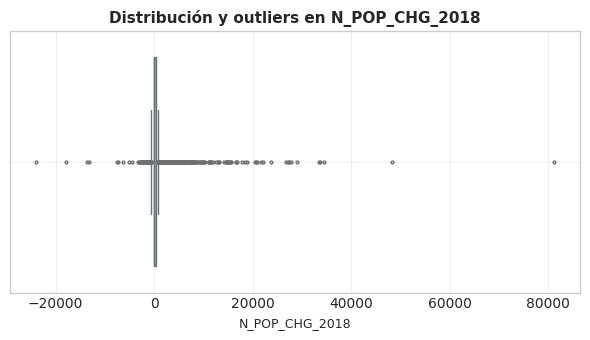

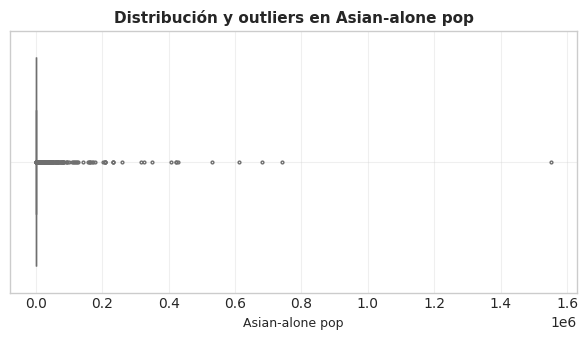

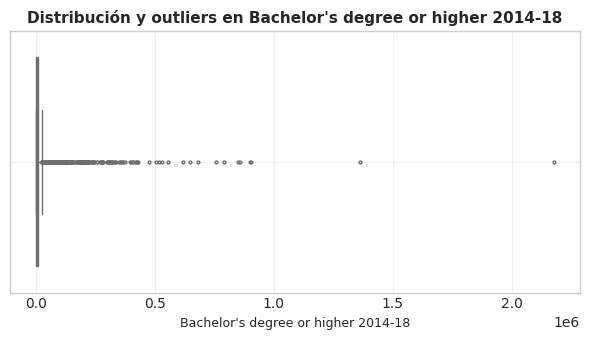

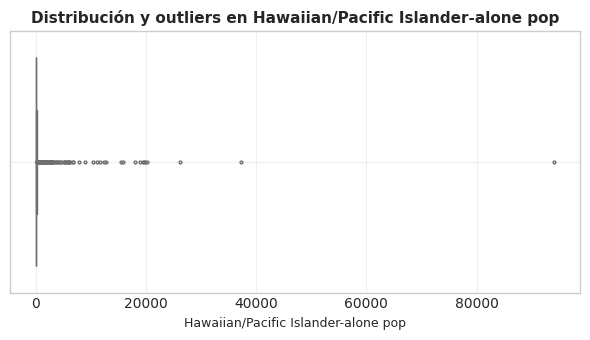

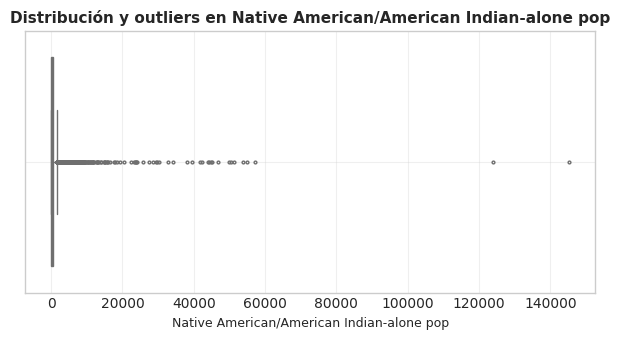

In [267]:
## Outliers y tratamiento

plt.style.use("seaborn-v0_8-whitegrid")

# Separar numéricas y categóricas
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

outlier_summary = []

# Outliers en variables numéricas (método IQR)
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    total = len(df)
    n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    perc = (n_outliers / total) * 100

    outlier_summary.append({
        "variable": col,
        "tipo": "numérica",
        "outliers": n_outliers,
        "%_outliers": perc,
        "q1": q1, "q3": q3, "IQR": iqr
    })

# Outliers en variables categóricas

    counts = df[col].value_counts(normalize=True)
    rare_values = counts[counts < 0.01]  # menos del 1% de la muestra
    if len(rare_values) > 0:
        outlier_summary.append({
            "variable": col,
            "tipo": "categórica",
            "outliers": len(rare_values),
            "%_outliers": rare_values.sum() * 100,
            "q1": np.nan, "q3": np.nan, "IQR": np.nan
        })

# resumen
outlier_df = pd.DataFrame(outlier_summary).sort_values("%_outliers", ascending=False)
display(outlier_df.head(20))

# Variables realmente relevantes para graficar ---
# Criterios: más del 10% de valores outliers o más de 50 casos
relevant_vars = (
    outlier_df[
        ((outlier_df["%_outliers"] > 10) | (outlier_df["outliers"] > 50))
        & (outlier_df["tipo"] == "numérica")
    ]
    .sort_values("%_outliers", ascending=False)
    .head(5)["variable"]
    .tolist()
)

print(f"Mostrando solo las 5 variables con mayor % de outliers: {relevant_vars}")

# Generar gráficos según el criterio anterior:
for var in relevant_vars:
    plt.figure(figsize=(6, 3.5))
    sns.boxplot(x=df[var], color="skyblue", fliersize=2)
    plt.title(f"Distribución y outliers en {var}", fontsize=11, fontweight="bold")
    plt.xlabel(var, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


El análisis de outliers confirma que una parte significativa de la variabilidad del dataset proviene de valores extremos en variables demográficas críticas.
El tratamiento controlado de estos casos permitirá obtener un modelo más robusto y representativo, evitando sesgos por dispersión excesiva o influencia de observaciones atípicas.
Hemos aplicado una windorización 1-99 al graficar la correlación con la matriz principal, pero tal vez se debería ponderar su peso en aquellas columnas que sea relevantes. Pueden reflejar realidades extremas en condados con tasas atípicas de migración, nacimientos o mortalidad.

## Regresión lineal
Tomamos la prevalencia de obesidad como predictor de nuestro proxy

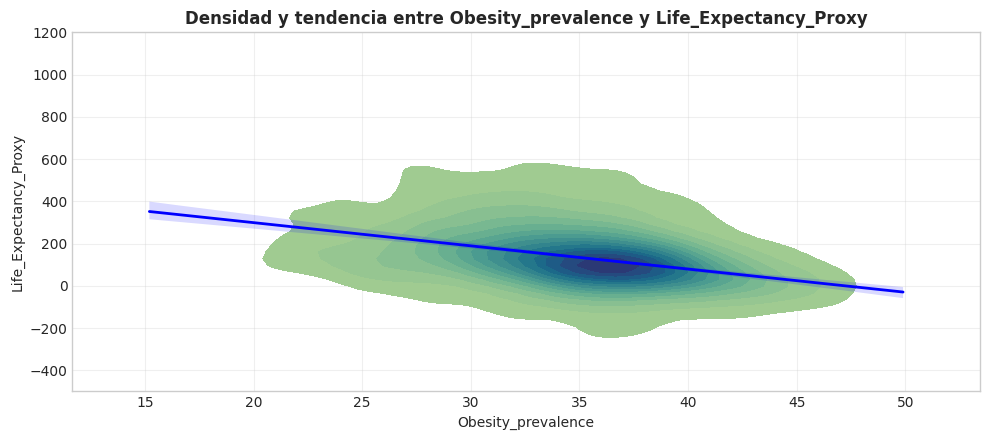

In [268]:
# prevalencia de la obesidad vs Esperanza de vida

predictor = "Obesity_prevalence"


plt.figure(figsize=(10, 4.5))
sns.kdeplot(
    data=df,
    x="Obesity_prevalence",
    y="Life_Expectancy_Proxy",
    fill=True,
    cmap="crest",
    thresh=0.05,
    levels=15
)
sns.regplot(
    data=df,
    x="Obesity_prevalence",
    y="Life_Expectancy_Proxy",
    scatter=False,
    color="blue",
    line_kws={"lw": 2}
)

plt.title(
    "Densidad y tendencia entre Obesity_prevalence y Life_Expectancy_Proxy",
    fontsize=12, fontweight="bold"
)
plt.xlabel("Obesity_prevalence", fontsize=10)
plt.ylabel("Life_Expectancy_Proxy", fontsize=10)
plt.ylim(-500, 1200)   # Límite del eje Y
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


La línea de regresión tiene pendiente descendente, lo que indica una correlación negativa entre la prevalencia de obesidad y la esperanza de vida. La zona de mayor densidad se encuentra entre 25 % y 40 % de obesidad, donde el proxy varía principalmente entre 0 y 300.

Esto sugiere que la mayoría de las regiones tienen niveles de obesidad moderados, y dentro de ese rango ya se percibe una tendencia descendente consistente.

In [269]:
df_model = df[["Obesity_prevalence", "Life_Expectancy_Proxy"]].dropna()

X = df_model[["Obesity_prevalence"]]
y = df_model["Life_Expectancy_Proxy"]

In [270]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [271]:
# Entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
coef = model.coef_[0]
intercept = model.intercept_


print(f"Intercepto (b0): {intercept:.3f}")
print(f"Coeficiente (b1): {coef:.3f}")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


Intercepto (b0): 535.273
Coeficiente (b1): -11.439
R²: 0.071
RMSE: 148.285


In [272]:
y_pred = model.predict(X_test)
y_pred

array([ 1.25757269e+02,  1.70369309e+02,  1.52066934e+02,  2.16125248e+02,
        6.39867524e+01,  1.05167097e+02,  1.23469472e+02,  1.42915746e+02,
        8.91525185e+01,  8.45769246e+01,  1.47491340e+02,  1.52066934e+02,
        1.15462183e+02,  1.46347441e+02,  1.42915746e+02,  1.65793715e+02,
        1.10886589e+02,  1.39484051e+02,  1.20037777e+02,  2.19556943e+02,
        1.06310995e+02,  5.94111585e+01,  1.63505918e+02,  1.26901168e+02,
        1.74944903e+02,  1.48635238e+02,  1.52066934e+02,  4.11087832e+01,
        1.05167097e+02,  1.23469472e+02,  2.35571521e+02,  1.31476762e+02,
        1.47491340e+02,  1.94391177e+02,  1.05167097e+02,  1.86383888e+02,
        1.69225411e+02,  1.07454894e+02,  1.37196254e+02,  3.19575955e+01,
        1.08598792e+02,  1.16606082e+02,  1.89815583e+02,  3.42453924e+01,
        2.74464069e+02,  1.30332863e+02,  7.08501431e+01,  8.57208231e+01,
        1.21181675e+02,  1.56642528e+02,  5.82672601e+01,  1.64649817e+02,
        1.07454894e+02,  

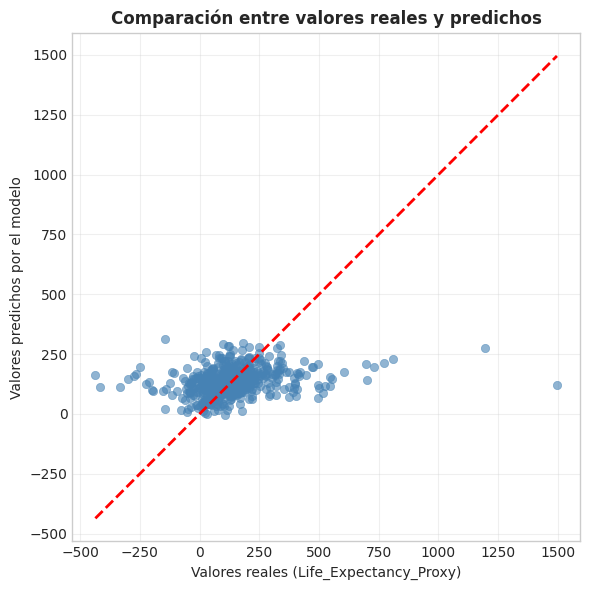

In [273]:
# Comparamos valores predecidos vs valores reales
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="steelblue", edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.title("Comparación entre valores reales y predichos", fontsize=12, fontweight="bold")
plt.xlabel("Valores reales (Life_Expectancy_Proxy)")
plt.ylabel("Valores predichos por el modelo")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Conclusión: el modelo de regresión lineal no parece el más adecuado para este análisis. Capta una tendencia negativa coherente pero sólo explica parcialmente la esperanza de vida. Parece estar condicionada por otras variables estructurales. Conforme aumentan los valores reales, los errores son mayores (heterocedasticidad baja) . El modelo precide valores más bajos de los reales.

## Regresión lineal múltiple
Usamos el modelo Lasso como se indica en el ejercicio.

In [274]:
print("Columnas incluidas en X:", X.columns.tolist())
print("Shape de X:", X.shape)


Columnas incluidas en X: ['Obesity_prevalence']
Shape de X: (3135, 1)


In [275]:
# Seleccionar variables
cols = [
    "Obesity_prevalence",
    "R_NET_MIG_2018",
    "R_death_2018",
    "Med_HH_Income_Percent_of_State_Total_2018",
    "CI90LBINC_2018",
    "Unemployment_rate_2018",
    "COPD_prevalence",
    "Percent of adults with a bachelor's degree or higher 2014-18"
]

df_model = df[["Life_Expectancy_Proxy"] + cols].copy()

# Imputar NaN con la mediana para evitar errores
df_model = df_model.fillna(df_model.median(numeric_only=True))

X = df_model[cols]
y = df_model["Life_Expectancy_Proxy"]

In [ ]:
# Aplicamos StandardScaler para reducir la penalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [277]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_multi = LinearRegression()
model_multi.fit(X_train, y_train)

y_pred_multi = model_multi.predict(X_test)

r2_multi = r2_score(y_test, y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y_test, y_pred_multi))

print("----- Modelo Multivariante -----")
print(f"R²: {r2_multi:.3f}")
print(f"RMSE: {rmse_multi:.3f}")
print("\nCoeficientes:")
for feature, coef in zip(X.columns, model_multi.coef_):
    print(f"{feature}: {coef:.3f}")

----- Modelo Multivariante -----
R²: 0.449
RMSE: 197.256

Coeficientes:
Obesity_prevalence: 3.791
R_NET_MIG_2018: 10.617
R_death_2018: -15.270
Med_HH_Income_Percent_of_State_Total_2018: 0.087
CI90LBINC_2018: 0.000
Unemployment_rate_2018: 1.338
COPD_prevalence: -4.472
Percent of adults with a bachelor's degree or higher 2014-18: 0.517


In [278]:
alphas = np.linspace(0, 20, 100)  # valores de α desde 0 hasta 20
r2_scores = []

for a in alphas:
    lasso = Lasso(alpha=a, random_state=42, max_iter=10000)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    r2 = r2_score(y_test, y_pred_lasso)
    r2_scores.append(r2)

/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py:1365: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.900e+06, tolerance: 5.211e+03
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_co

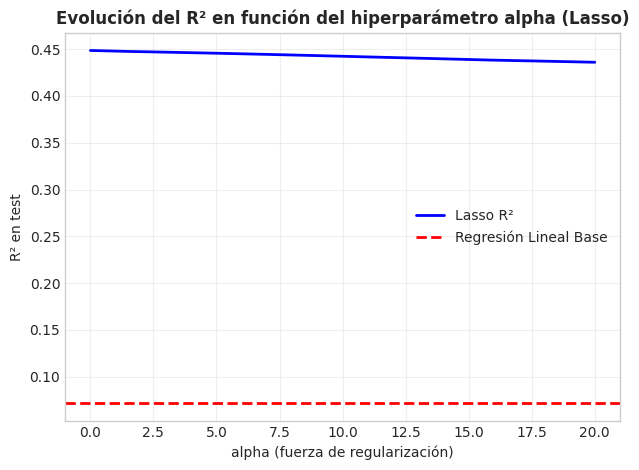

In [279]:
# Graficamos
plt.plot(alphas, r2_scores, label="Lasso R²", color="blue", linewidth=2)
plt.axhline(y=r2_lin, color="red", linestyle="--", linewidth=2, label="Regresión Lineal Base")
plt.title("Evolución del R² en función del hiperparámetro alpha (Lasso)", fontsize=12, fontweight="bold")
plt.xlabel("alpha (fuerza de regularización)")
plt.ylabel("R² en test")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

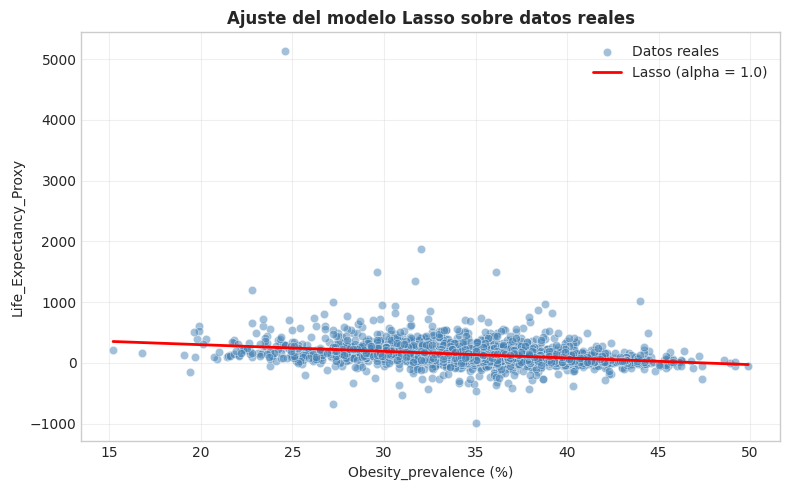

In [280]:
df_model = df[["Obesity_prevalence", "Life_Expectancy_Proxy"]].dropna()
X = df_model[["Obesity_prevalence"]]
y = df_model["Life_Expectancy_Proxy"]

# modelo lasso
lasso = Lasso(alpha=1.0, random_state=42, max_iter=10000)
lasso.fit(X, y)

# predicciones para el conjunto
y_pred_lasso = lasso.predict(X)

# graficamos
plt.figure(figsize=(8, 5))

sns.scatterplot(x=X["Obesity_prevalence"], y=y, alpha=0.5, color="steelblue", label="Datos reales")

sns.lineplot(
    x=X["Obesity_prevalence"].sort_values(),
    y=y_pred_lasso[np.argsort(X["Obesity_prevalence"].values)],
    color="red",
    linewidth=2,
    label=f"Lasso (alpha = {lasso.alpha})"
)

plt.title("Ajuste del modelo Lasso sobre datos reales", fontsize=12, fontweight="bold")
plt.xlabel("Obesity_prevalence (%)", fontsize=10)
plt.ylabel("Life_Expectancy_Proxy", fontsize=10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Los puntos azules son mis datos reales (obesity_prevalence vs Life_expectancy_Proxy) y la línea roja muestra la recta ajustada con el modelo Lasso. 

El nuevo R2 explica aprox. 45% de la variabilidad de Life_Expectancy_Proxy, mejorando el 7% del modelo simple. 

El RMSE es de 197.26 (error medio de predcción)
-Obesity_prevalence y unemployment_rate: si es negativo reduce la esperanza de vida. Da un positivo inesperado en cada variable tras el cruce con otras variables
-Las regiones con mayor inmigración tienen a tener una esperanza de vida más alta (mejor economía)
-A mayor nivel de educación, mayor proxy
-A mayor COPD (enfermedad pulmonar crónica) mayor reducción de esperanza de vida
-CI90LBINC_2018 ingreso medio del hogar. Resultado poco significativo
-Efecto socioeconómico: mayor ingreso medio estatal mayor proxy. Med_HH_Income_Percent_of_State_Total_2018